<a href="https://colab.research.google.com/github/manyasha-n-m/OT-tutorials/blob/main/Tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hands-on Tutorials on Computational Optimal Transport
### Instructor: Nataliia Monina
-----

### 1. Optimal Transport in discrete setting: examples
In this notebook, we'll:
1. Learn the basics of discrete Optimal Transport (OT) with and without regularization
2. Explore how the regularization parameter affects solutions (Plans)
3. Compute averages of measures/pictures via Wasserstein barycenters and compare them with Euclidean means.



In this introduction tutorial, we will fix some notations and consider basic implementations possibly used in later sessions.

Key initial points:

- `POT` library -- already implemented code examples for solving/approximating Optimal Transort plans.
- Demonstration on 2 main (simple-case) examples: for $\mathbb{R}^1$ and for $\mathbb{R}^2$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ot
import ot.plot
%matplotlib inline

# General objects:

### Space of coordinates
- $X = \{x_0,\dots, x_{n-1}\}, ~ Y = \{y_0,\dots, y_{m-1}\}$ -- Sets of points in $\mathbb{R}^d$.


### Probability distributions
- $\mu = (\mu_0, \dots, \mu_{n-1}), ~\nu =  (\nu_0, \dots, \nu_{m-1})$ -- Probability distributions on $X$ and $Y$, respectively \\
In this notation, we can say that the "probability" of the object to be at the point $x_i$ is equal to $\mu_i$.


### Cost matrix
- $C = \begin{pmatrix} C_{00} & \dots & C_{0 (m-1)}\\
\vdots & \ddots & \vdots \\
C_{(n-1)0} & \dots & C_{(n-1)(m-1)}
\end{pmatrix}$ -- $C_{ij}$ tells how much we would "pay" to transport a unit of mass from the point $x_i$ to $y_j$.


### Let's now visualize some of them


### Example 1: $\mathbb R^1$ Gaussians and Coulomb-like cost
$c_1(x,y) = \frac{1}{1+|x-y|}$, e.g. $C_1[i,j] = \frac{1}{(1+ |X_1[i]-Y_1[j]|)}$

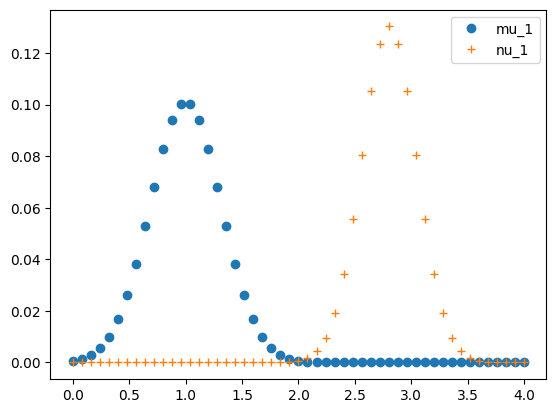

In [2]:
'''Example 1'''

X_1 = np.linspace(0,4, 51)
Y_1 = np.linspace(0,4, 51)

def discrete_gaussian(mean, variance, interval):
    f = np.exp(-(interval-mean)**2/(2*variance)) / np.sqrt(2*np.pi*variance)
    return f/f.sum()

mu_1 = discrete_gaussian(1, 0.1, X_1)
nu_1 = discrete_gaussian(2.8, 0.06, Y_1)

'''Example 1: Test measures'''

plt.figure(2)
plt.plot(X_1, mu_1, 'o', label="mu_1")
plt.plot(Y_1, nu_1, '+', label="nu_1")
plt.legend(loc=0)

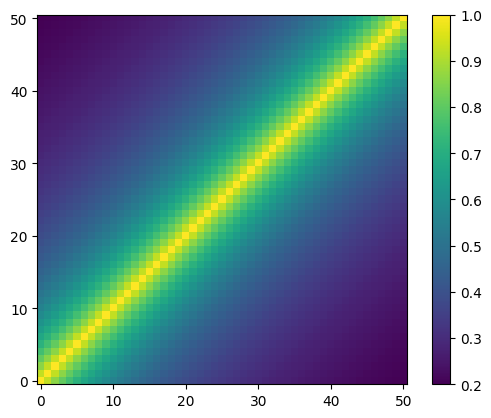

In [3]:
'''Example 1: Coulomb cost '''

C_1 = 1 / (1 + np.abs(X_1[:, None] - Y_1[None, :]))


# How does it look like?
plt.figure(3)
img = plt.imshow(C_1, origin='lower')
pbar = plt.colorbar(img)
plt.show()

# the biggest values are on the diagonal and decay away from the diagonal

Side comment: the numbers 0, 1, 2, ... and so on on this plots represent the indeces of the points in our spaces $X$ or $Y$. The upper left corner corresponds to $(x_0, y_0)$ up to the bottom right corner $(x_{n-1}, y_{m-1})$

UPD Not anymore

### Example 2: $\mathbb R^2$ points and distance square
$c_2(x,y) = ||x-y||^2$,  e.g. $C_2[i,j] = ||X_2[i]-Y_2[j]||^2$

/var/folders/15/jlg3w5bs0397x9n4mllqps3h0000gn/T/ipykernel_86638/3032154760.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


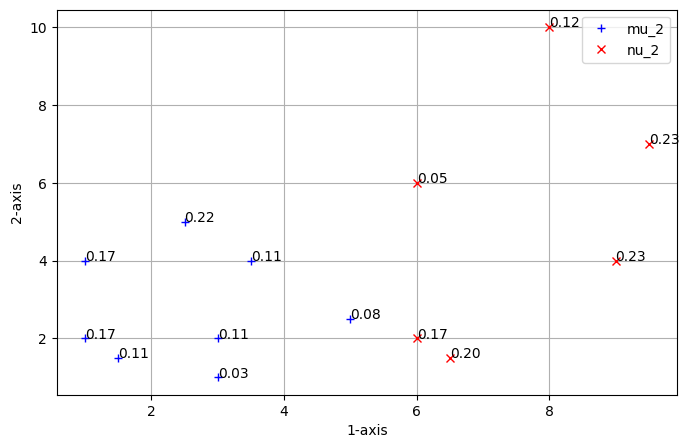

In [4]:
''' Example 2'''

X_2 = np.array([[1, 2],
                [3, 1],
                [1.5, 1.5],
                [3, 2],
                [2.5, 5],
                [3.5, 4],
                [1, 4],
                [5, 2.5]])

Y_2 = np.array([[8, 10],
                [6.5, 1.5],
                [6, 2],
                [9.5, 7],
                [9, 4],
                [6, 6],])

'''Example 2: Random valued test measures'''
np.random.seed(0)
# random values of mass at points of X_2 and Y_2, respectively
rand_21 = np.random.randint(1, 10, size=len(X_2))
rand_22 = np.random.randint(1, 10, size=len(Y_2))

# normalize the mass into "probabilities"
mu_2 = rand_21/rand_21.sum()
nu_2 = rand_22/rand_22.sum()

fig, ax = plt.subplots(figsize=(8,5))
ax.grid()
ax.plot(X_2[:, 0], X_2[:, 1], '+b', label='mu_2')

for i, val in enumerate (mu_2):
    ax.annotate(f'{val:.2f}', X_2[i])

plt.plot(Y_2[:, 0], Y_2[:, 1], 'xr', label='nu_2')
for i, val in enumerate (nu_2):
    ax.annotate(f'{val:.2f}', Y_2[i])

ax.legend(loc=0)
ax.set(xlabel='1-axis')
ax.set(ylabel='2-axis')
fig.show()

1-axis has: 8 points -- number of points from X
2-axis has: 6 points -- number of points from Y


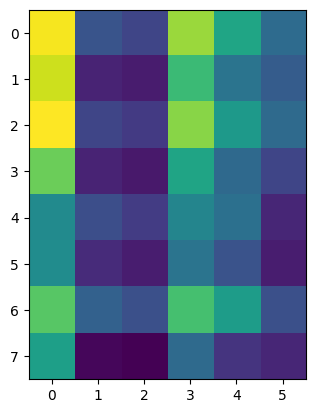

In [5]:
'''Example 2: Distance squared'''

C_2 = ot.dist(X_2, Y_2, metric='sqeuclidean')

# C[i, j] tells you how much we "pay" to transfer mass from the point X[i]=(x1, x2) to Y[j]=(y1, y2)

plt.figure(4)
plt.imshow(C_2)

print(f"1-axis has: {len(X_2)} points -- number of points from X")
print(f"2-axis has: {len(Y_2)} points -- number of points from Y")

# OT objects:
### Couplings of $\mu$ and $\nu$ (or joint probability distributions)
- $P = \begin{pmatrix} P_{00} & \dots & P_{0 (m-1)}\\
\vdots & \ddots & \vdots \\
P_{(n-1)0} & \dots & P_{(n-1)(m-1)}
\end{pmatrix}$ -- possible "coupling" between $\mu$ and $\nu$, i.e. such that $\sum\limits_{i=0}^{n-1} P_{ij} = \nu_{j}$ and $\sum\limits_{j=0}^{m-1} P_{ij} = \mu_i$.

- One of the ways to view $P_{ij}$ is: How much mass we will take from the point $x_i$ and send to $y_j$.

- Another viewpoint: $P_{ij}$ says what is the "probability" of the object to be at the point $(x_i,y_j)$.


## What do we want to compute (approximate) in Optimal Transport?

- $P^*\in argmin \{F_C(P) := \sum\limits_{i=0}^{n-1}\sum\limits_{j=0}^{m-1}C_{ij}P_{ij} \,:\, P_{ij}\geq 0, \, \sum\limits_{i=0}^{n-1} P_{ij} = \nu_{j}, \, \sum\limits_{j=0}^{m-1} P_{ij} = \mu_i\}$

- **Remark:** From now on, it doesn't matter "what" are the coordinates where our "mass" is, so the *dimension of $X$ or $Y$ is not relevant*. Everything necessary is already encoded in $\mu, ~\nu$ and $C$.

Let's plot the examples of $P$. It is very nice to look at those big matrices in terms of heatmaps. In the pictures below, each pixel of the "square" contains a value: "How much mass to take from $x_i$ and move to $y_j$", so it is simply a color representation of the matrix $P$.

Also, if you sum the matrix vertically, you will get the graph on the top -- distribution $\nu$. Similarly, if you sum horizontally, we get the graph on the left -- distrubution $\mu$.

### **Fact**: if you take a matrix $P_{ij} = \mu_i \times \nu_{j}$, it always satisfies the "marginal" conditions
##### However, this particular $P$ is never the best solution for the Optimal Transport problem

### Example 1:

(<Axes: >, <Axes: >, <Axes: >)

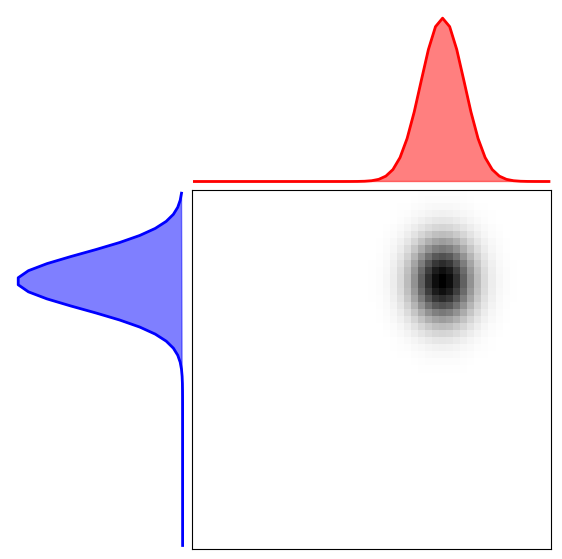

In [6]:
P_1_bad = mu_1[:, None] * nu_1[None, :]

plt.figure(5, figsize=(7,7))
ot.plot.plot1D_mat(mu_1, nu_1, P_1_bad) # main method for visualizing plans

**Important fact:** typically, the best solution will look almost like a "line" or a "curve" when you look at the picture. It can help us to see "how good" we are estimating the solution, more or less it is a "sanity check".

For this time being, we can use some already implemented methods available in the `POT` library.

### **First method**: solve the original problem (via Linear Programming, e.g., `POT` library)

- Pros: provides the best approximation to the solution of the problem.

- Cons: takes very long to compute, cannot use any gradient methods and so on.

(<Axes: >, <Axes: >, <Axes: >)

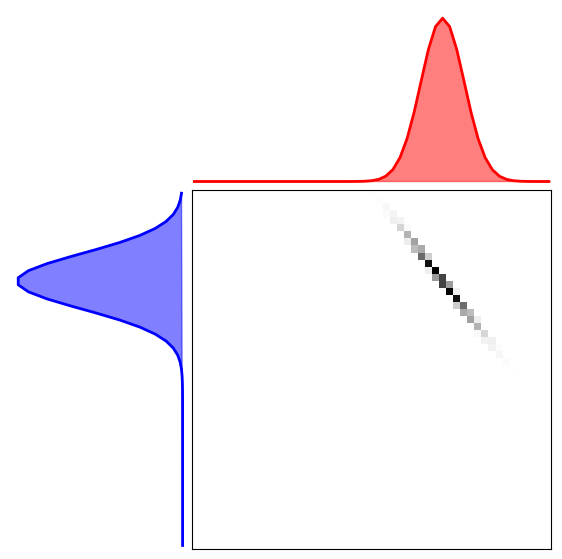

In [7]:
P_1_best = ot.emd(mu_1, nu_1, C_1)

plt.figure(7, figsize=(7,7))
ot.plot.plot1D_mat(mu_1, nu_1, P_1_best)

Coulomb cost is actually more interesting when the marginals are identical

Let's see what happens:

(<Axes: >, <Axes: >, <Axes: >)

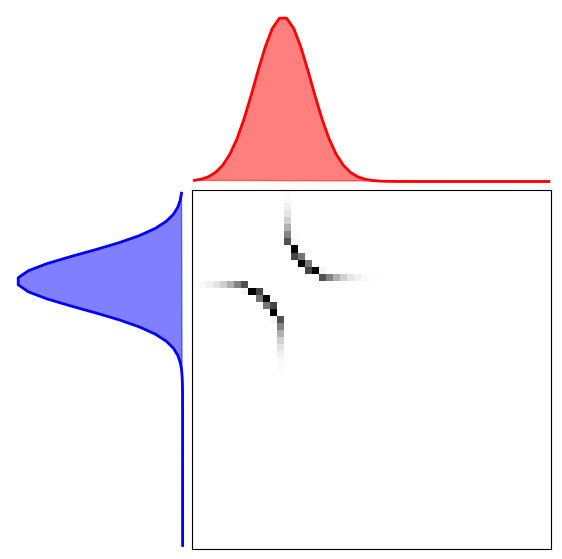

In [8]:
P_1_best_same_marginals = ot.emd(mu_1, mu_1, C_1)

plt.figure(7, figsize=(7,7))
ot.plot.plot1D_mat(mu_1, mu_1, P_1_best_same_marginals)

#### Exercises:

- Example 1:
    1. Generate distance squared for Example 1 and look at the solutions of OT for pairs (`mu_1`, `nu_1`) and (`mu_1`, `mu_1`) with this cost
    3. (Optional) for fixed `mu` consider a "moving" `nu`. i.e., an array of several `[nu_0, nu_1,...,nu_k]`and compare solutions between (`mu`, `nu_j`). Then try a different cost and repeat
        
- Example 2:
    1. Solve OT for our 2d (Example 2) here for C_2 and (`mu_2`, `nu_2`)

- Both examples: compare the values of $F_C$(P_bad), e.g., product measure, and $F_C$(P_best), e.g., solution by `ot.emd`

(<Axes: >, <Axes: >, <Axes: >)

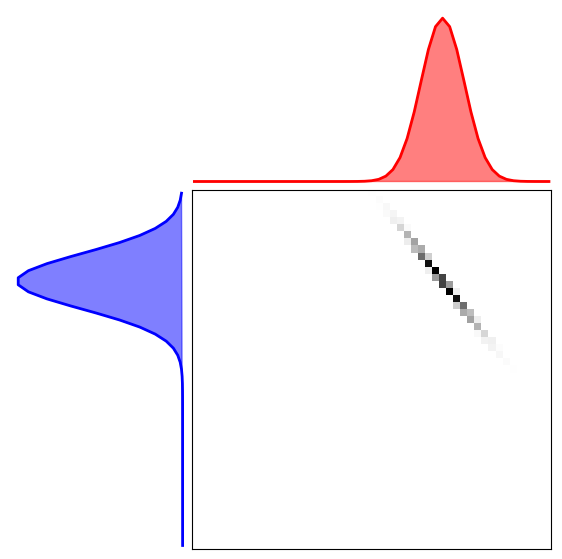

In [9]:
''' Example 1'''

C_sqeuq = (X_1[:, None] - Y_1[None, :]) ** 2
P_1_best_sqeuq = ot.emd(mu_1, nu_1, C_sqeuq)

plt.figure(7, figsize=(7,7))
ot.plot.plot1D_mat(mu_1, nu_1, P_1_best_sqeuq)

(<Axes: >, <Axes: >, <Axes: >)

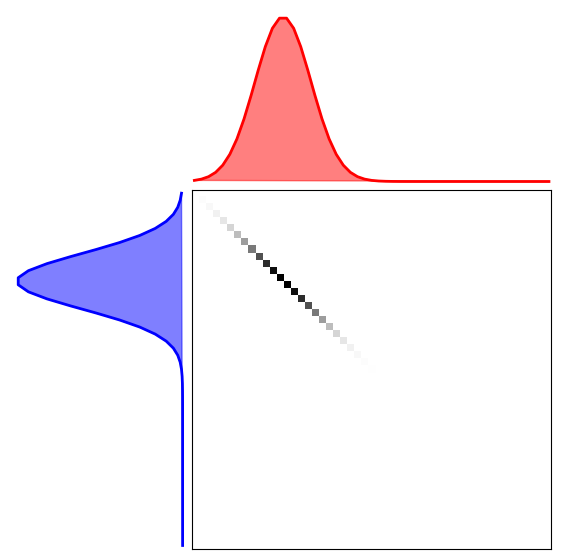

In [10]:
P_1_best_sqeuq = ot.emd(mu_1, mu_1, C_sqeuq)

plt.figure(7, figsize=(7,7))
ot.plot.plot1D_mat(mu_1, mu_1, P_1_best_sqeuq)

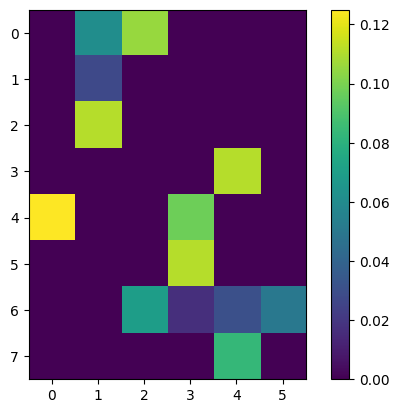

In [11]:
'''Example 2'''

P_2_best = ot.emd(mu_2, nu_2, C_2)
img = plt.imshow(P_2_best)
pbar = plt.colorbar(img)
plt.show()

In [12]:
'''Both examples: comparison of values of OT'''

cost_1_bad = (C_1 * P_1_bad).sum()
cost_1_best = (C_1 * P_1_best).sum()

print(cost_1_bad, cost_1_best)

0.36498416377179077 0.35748940205729796


In [13]:
P_2_bad = mu_2[:, None] * nu_2[None, :]

cost_2_bad = (C_2 * P_2_bad).sum()
cost_2_best = (C_2 * P_2_best).sum()

print(cost_2_bad, cost_2_best)

46.40416666666666 37.425694444444446


### **Second method**: solve the regularized problem (Sikhorn algorithm). (Can still use `POT` here for now)

Fix $\varepsilon>0$. Now instead we are looking for a solution of

$P^{\varepsilon}\in argmax \{F^{\varepsilon}_C(P) := \sum\limits_{i=0}^{n-1}\sum\limits_{j=0}^{m-1}C_{ij}P_{ij} +\varepsilon \sum\limits_{i=0}^{n-1}\sum_{j=0}^{m-1} P_{ij}(\log P_{ij}-1)\,:\, P_{ij}\geq 0, \, \sum\limits_{i=0}^{n-1} P_{ij} = \nu_{j}, \, \sum\limits_{j=0}^{m-1} P_{ij} = \mu_i\}$



- Pros: can define a nice algorithm that is faster to compute, provides approximation to the solution of the problem for $\varepsilon$ small enough.

- Cons: the solution is never exact, may get to the point when there is a division by almost 0.

Let's solve the problem for different values of $\varepsilon$ to see how it affects the solutions.


In [14]:
# helpful function to plot and analyze and compare our solutions
def analyze_solutions(mu, nu, P_computed, P_for_compare, epsilon, C):
    """
    Parameters
    ----------
    mu: np.ndarray
        Actual measure mu
    nu: np.ndarray
        Actual measure nu
    P_computed: np.ndarray
        Computed plan P with the chosen method
    P_for_compare: np.ndarray
        Reference plan P to compare with (e.g., output of ot.emd)
    C: 
        Cost matrix

    Returns
    -------
    plt.figure
        Plot of comparisons for our computed solution
    """

    plt.figure()
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    # error of marginals
    # mu vs. output
    ax[0].plot(mu)
    ax[0].plot(np.sum(P_computed, axis=1))
    ax[0].set_title('mu vs P_computed_mu')
    # nu vs. output
    ax[1].plot(nu)
    ax[1].plot(np.sum(P_computed, axis=0))
    ax[1].set_title('nu vs P_computed_nu')

    # comparison of plans
    ax[2].imshow(P_computed)
    ax[2].set_title(f"P_computed (eps={epsilon})")
    ax[3].imshow(P_for_compare)
    ax[3].set_title(f"P_for_compare (eps={epsilon})")

    print("Cost of P_computed:", np.einsum('ij,ij', C, P_computed))
    print("Cost of P_for_compare:", np.einsum('ij,ij', C, P_for_compare))
    return ax


Cost of P_computed: 0.36081353488478773
Cost of P_for_compare: 0.35748940205729807


<Figure size 640x480 with 0 Axes>

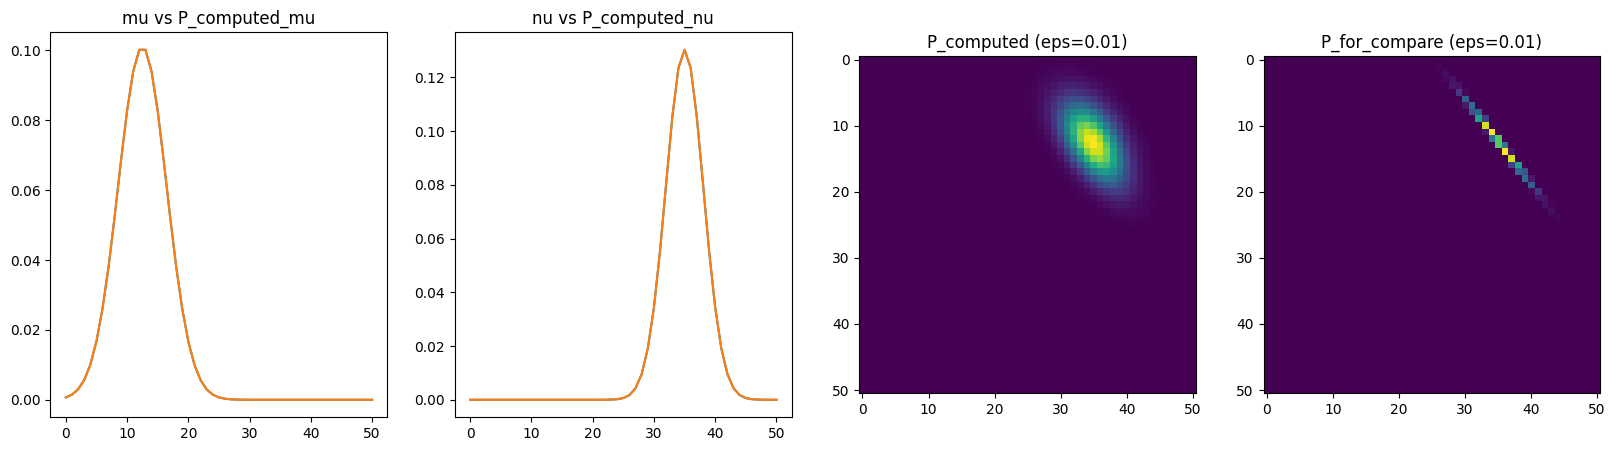

In [15]:
epsilon = 0.01

P_001 = ot.sinkhorn(mu_1, nu_1, C_1, epsilon)

analyze_solutions(mu_1, nu_1, P_001, P_1_best, epsilon, C_1)
plt.show()

## Role of $\varepsilon$: how much it affects the solution?

interactive(children=(FloatSlider(value=0.001, description='eps', max=0.1, min=0.001, step=0.001), Output()), …

<Figure size 640x480 with 0 Axes>

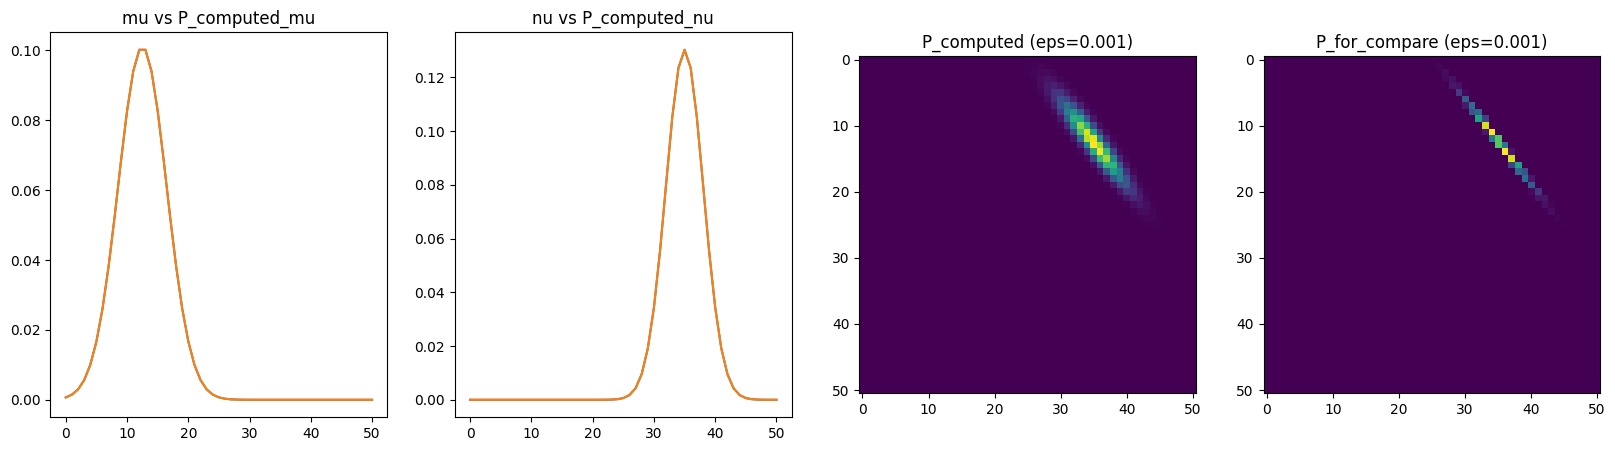

In [16]:
from ipywidgets import interact

def explore_eps(eps=0.001):
    P_different_eps = ot.sinkhorn(mu_1, nu_1, C_1, eps)
    return analyze_solutions(mu_1, nu_1, P_different_eps, P_1_best, eps, C_1)

interact(explore_eps, eps=(0.001, 0.1, 0.001));

In [17]:
'''Place to play around with different measures, costs and other parameters'''


'Place to play around with different measures, costs and other parameters'

### Wasserstein Barycenters

Optimal transport plays a crucial part in numerical methods for comparing measure-like objects. It gives nice geometrical interpretations of distances and averages between probability distributions. In this part we will compare Euclidean and Wasserstein barycenters (weigthed averages) of 1d measures and pictures (as 2d measures)

Given probability distributions $ \mu^1, \dots, \mu^N $ and weights $ \lambda_1, \dots, \lambda_N \geq 0 $ with $ \sum_i \lambda_i = 1 $, the **Wasserstein barycenter** is the "average" distribution $ \nu $ that minimizes

$$
\nu^* = \arg\min_\nu \sum_{k=1}^N \lambda_k W_2(\nu, \mu^k),
$$

where (in discrete setting):
- $ W_2^2(\nu, \mu) = min \{\sum_{ij}P_{ij} C_{ij} : \sum_j P_{ij}=\mu_i, \sum_i P_{ij}=\nu_j\} $ is the **Wasserstein distance**
- $ C_{ij} = d(x_i,y_j)^2 $ is the cost function induced by a distance.
- Often solved with entropic regularization parameter $ \varepsilon > 0 $, e.g. basically involving Sinkhorn algorithm


Unlike a **pixelwise (Euclidean) average**
$$ \tilde \mu = \frac1N\sum_{k=1}^N\mu^k$$
which simply blends intensities, the Wasserstein barycenter:
- **Moves mass** to align structures (e.g., shifts strokes in digits),
- Produces a result that is **sharper and more meaningful** as a "typical" element.

---

#### How `ot.bregman.barycenter` works?

POT’s `ot.bregman.barycenter` iteratively computes the *entropy-regularized* (for $\varepsilon>0$) Wasserstein average of several distributions by solving many small Sinkhorn OT problems and blending the results. The entropic regularization makes it fast and smooth, so we can use it on images like MNIST easily.

**However, due to regularization, entropic barycenter has errors (you can see even when choosing $\lambda=0$  or 1)**


#### Example $\mathbb R^1$
Let's compute barycenter for measures `mu_1` and `nu_1` from Example 1 but with distance squared.
We shall assume, for simplicity, that they are defined on the **same** interval and with the same number of discretization points.


interactive(children=(FloatSlider(value=0.5, description='lambda_', max=1.0, step=0.05), Output()), _dom_class…

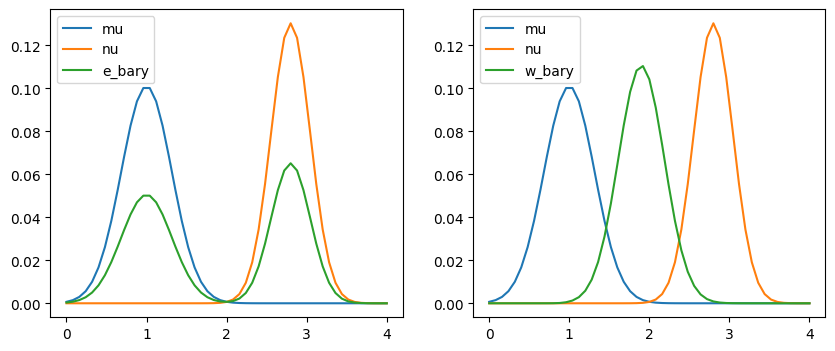

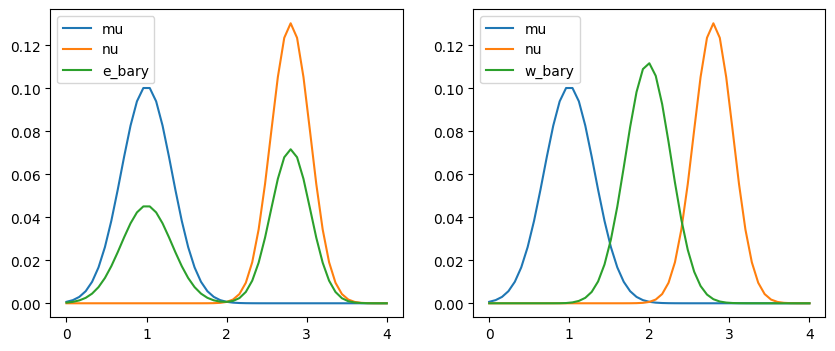

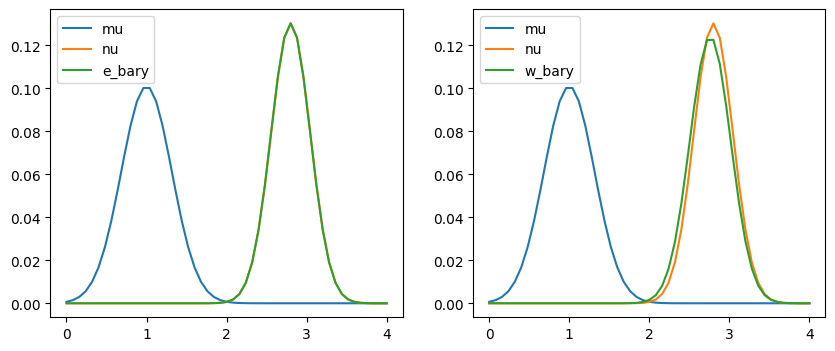

In [18]:
'''Example 1'''

# take C as distance squared

C = ot.dist(X_1[:, None], Y_1[:, None])
eps = 0.009

def compare_barycenter(lambda_=0.5):
    """lambda_ = weight for mu (nu gets 1-lambda_)"""
    weights = np.array([lambda_, 1-lambda_])

    # Stack the distributions (flattened vectors)
    A = np.array([mu_1, nu_1])

    # Compute Wasserstein barycenter (entropic)
    w_bary = ot.bregman.barycenter(A.T, C, reg=eps, weights=weights)

    # Compute Euclidean barycenter (simple weighted average)
    e_bary = lambda_*mu_1 + (1-lambda_)*nu_1

    # Plot everything
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(X_1, mu_1, label="mu")
    axes[0].plot(X_1, nu_1, label="nu")
    axes[0].plot(X_1, e_bary, label="e_bary")
    axes[0].legend()
    axes[1].plot(X_1, mu_1, label="mu")
    axes[1].plot(X_1, nu_1, label="nu")
    axes[1].plot(X_1, w_bary, label="w_bary")
    axes[1].legend()


interact(compare_barycenter, lambda_=(0.0, 1.0, 0.05));

#### Example with Mnist dataset

Here we will choose several samples of a number from Mnist dataset and compute the picture "on average" by finding Euclidean and Wasserstein barycenter.

In [19]:
'''Example with mnist'''
from tensorflow.keras.datasets import mnist
(x_train, y_train), (_, _) = mnist.load_data()

# x_train contains images, y_train contains names (labels) of the them

11490434/11490434 [==============================] - 28s 2us/step


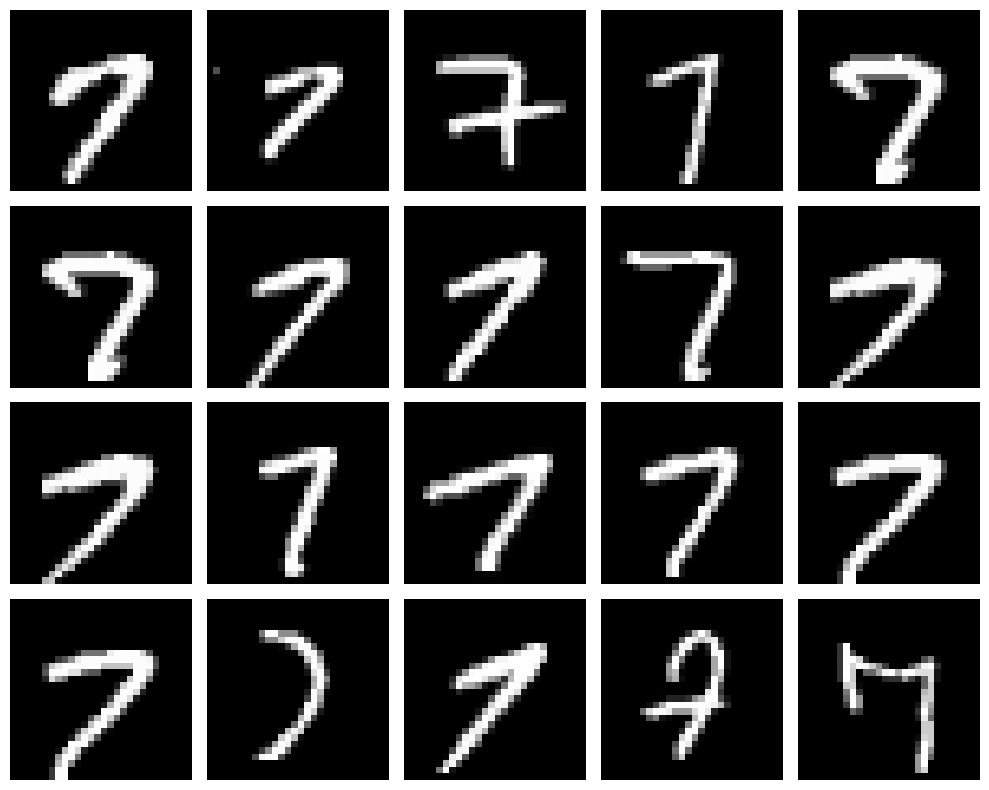

'These are the samples that we want to average'

In [57]:
'''Choose a mnist digit to experiment with'''

digit = 7
num_samples = 20  # how many samples to average
indices = np.where(y_train == digit)[0][:num_samples]
images = x_train[indices].astype(np.float32)

# Normalize each image to be a probability distribution
images = images / np.sum(images, axis=(1,2))[:, None, None]

# let's plot them to see what they look like
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

for i in range(4):
    for j in range(5):
        axes[i,j].imshow(images[4*i+j], cmap="gray")
        axes[i,j].axis('off')

plt.tight_layout()
plt.show()

"""These are the samples that we want to average"""

In [58]:
images_aug = np.zeros((num_samples, 50, 50))

for i in range(num_samples):
    a, b = np.random.randint(0, 22, 2)
    images_aug[i][a:a+28, b:b+28] = images[i]

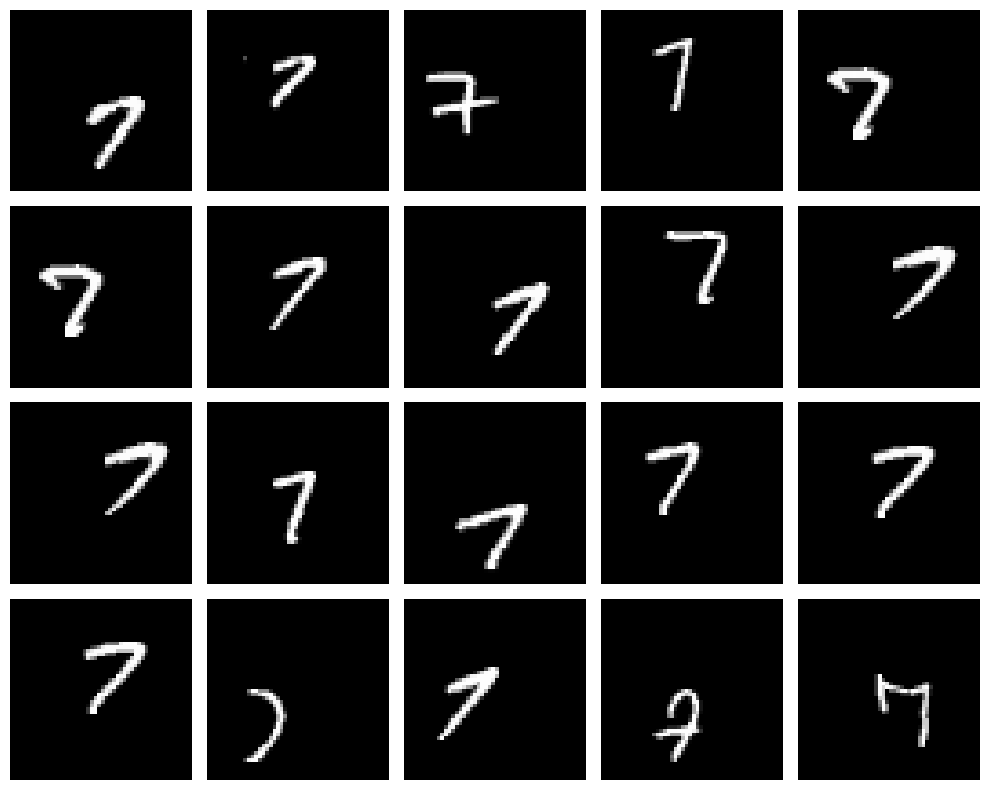

'These are the samples that we want to average'

In [59]:
# let's plot them to see what they look like
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

for i in range(4):
    for j in range(5):
        axes[i,j].imshow(images_aug[4*i+j], cmap="gray")
        axes[i,j].axis('off')

plt.tight_layout()
plt.show()

"""These are the samples that we want to average"""

In [63]:
images = images_aug[:10, :, :]

# prepare sata for Wasserstein barycenter
A = np.array([img.flatten() for img in images])  # shape (20, 784)
weights = np.ones(len(images)) / len(images)  # uniform average

# Build cost matrix (pixel coordinate distances)
x = np.arange(images.shape[-1])
X, Y = np.meshgrid(x, x)
coords = np.stack([X.flatten(), Y.flatten()], axis=1, dtype=np.float64)
C = ot.dist(coords, coords, metric='sqeuclidean')
C /= C.max()

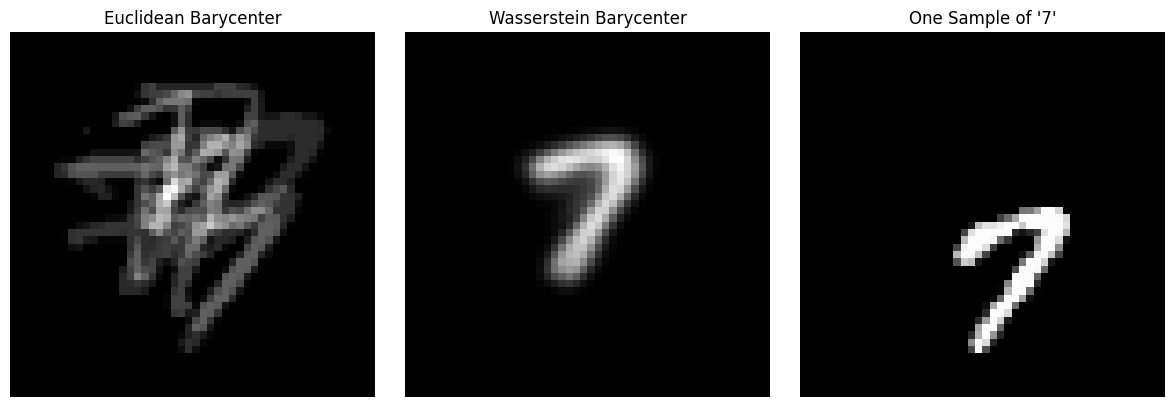

In [64]:
# Entropic Wasserstein Barycenter
w_bary = ot.bregman.barycenter(A.T, C, reg=0.0005, weights=weights)
w_bary_img = w_bary.reshape(*images.shape[1:])

# Comparison
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(np.mean(images, axis=0), cmap="gray")
axes[0].set_title("Euclidean Barycenter")
axes[0].axis("off")

axes[1].imshow(w_bary_img, cmap="gray")
axes[1].set_title("Wasserstein Barycenter")
axes[1].axis("off")

axes[2].imshow(images[0], cmap="gray")
axes[2].set_title(f"One Sample of '{digit}'")
axes[2].axis("off")

plt.tight_layout()
plt.show()